# AI API anomaly detector using graph neural networks models

### Import modules

In [102]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToDense
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv
import torch_geometric.utils
from torch_geometric.data import Batch, Data
from torch.nn.functional import pad
from sklearn.model_selection import train_test_split
import random
import json
import pandas as pd

### Define the GCN model

In [103]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 256)
        self.conv2 = GCNConv(256, 256)
        self.conv3 = GCNConv(256, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.unsqueeze(0)
        x = self.dropout(F.relu(self.conv1(x, edge_index)))
        x = self.dropout(F.relu(self.conv2(x, edge_index)))
        x = self.conv3(x, edge_index)
        x = x.squeeze(0)
        return F.log_softmax(x, dim=1)

### Load and process graph data

In [104]:
data_path = 'data'
csv_path = f'{data_path}\supervised_dataset.csv'
json_path = f'{data_path}\supervised_call_graphs.json'

data_frame = pd.read_csv(csv_path)
print(f"Loaded {len(data_frame)} records from CSV file.")
graph_data = json.load(open(json_path, 'r'))
print(f"Loaded {len(graph_data)} records from JSON file.")

print("Dataframe columns:", data_frame.columns)
print("Graph data keys:", graph_data[0].keys())
#print("Graph data sample:", graph_data[1])

Loaded 1699 records from CSV file.
Loaded 1699 records from JSON file.
Dataframe columns: Index(['Unnamed: 0', '_id', 'inter_api_access_duration(sec)',
       'api_access_uniqueness', 'sequence_length(count)',
       'vsession_duration(min)', 'ip_type', 'num_sessions', 'num_users',
       'num_unique_apis', 'source', 'classification'],
      dtype='object')
Graph data keys: dict_keys(['_id', 'call_graph'])


### Create mappings from IDs to labels

In [105]:
id_to_label = {item['_id']: (0 if item['classification'] == 'normal' else 1) for item in data_frame.to_dict('records')}

class_counts = pd.Series([id_to_label[_id] for _id in id_to_label]).value_counts() #check the distribution of the classes
print(class_counts)

0    1106
1     572
Name: count, dtype: int64


### Define useful functions

In [106]:
def create_graph_objects(graph_data, id_to_label):
    graphs = []
    for item in graph_data:
        _id = item['_id']
        
        # Process to ensure edge indices are numeric and consecutive
        node_ids = {}
        edge_indices = []
        for edge in item['call_graph']:
            from_id = edge['fromId']
            to_id = edge['toId']
            
            if from_id not in node_ids:
                node_ids[from_id] = len(node_ids)
            if to_id not in node_ids:
                node_ids[to_id] = len(node_ids)
            
            edge_indices.append([node_ids[from_id], node_ids[to_id]])
        
        # Convert edge_indices list to a tensor
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices else torch.empty((2, 0), dtype=torch.long)

        # Number of nodes and feature matrix
        num_nodes = len(node_ids)
        num_features = 10  # Choose an appropriate number of features
        x = torch.zeros(num_nodes, num_features)  # Initialize feature matrix with zeros
        for node_id, i in node_ids.items():
            x[i, i % num_features] = 1  # One-hot encoding of node index
        
        # Get the label and repeat it for each node
        label = torch.tensor([id_to_label[_id]] * num_nodes, dtype=torch.long)

        graphs.append(Data(x=x, edge_index=edge_index, y=label, num_nodes=num_nodes))

    return graphs

def collate(data_list):
    return Batch.from_data_list(data_list)

def oversample_minority(graphs):
    # Count the number of instances for each class
    class_counts = pd.Series([graph.y[0].item() for graph in graphs if graph.y.nelement() > 0]).value_counts()
    
    # Identify the minority class
    minority_class = class_counts.idxmin()
    
    # Calculate the difference between the majority and minority class
    diff = class_counts.max() - class_counts.min()
    
    # Get all graphs of the minority class
    minority_graphs = [graph for graph in graphs if graph.y.nelement() > 0 and graph.y[0].item() == minority_class]
    
    # Duplicate the minority graphs until the classes are balanced
    duplicate_graphs = random.choices(minority_graphs, k=diff)
    
    # Add the duplicated graphs to the original list
    graphs += duplicate_graphs

    return graphs

def print_label_distribution(graphs):
    # Count the number of instances for each class
    class_counts = pd.Series([graph.y[0].item() for graph in graphs if graph.y.nelement() > 0]).value_counts()
    
    print(class_counts)

### Create graphs

Created 2217 graph objects.
Graph object sample: Data(x=[447, 10], edge_index=[2, 2821], y=[447], num_nodes=447)


ValueError: Input could not be cast to an at-least-1D NumPy array

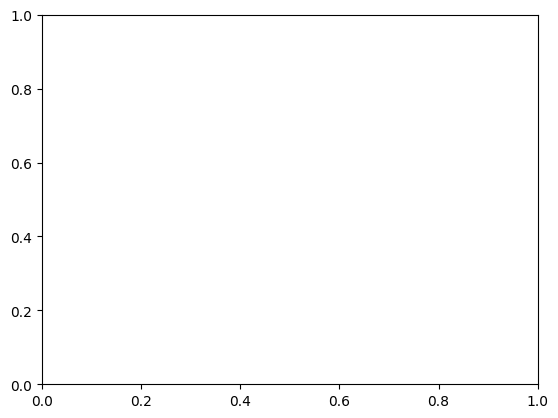

In [107]:
graphs = create_graph_objects(graph_data, id_to_label)
graphs = oversample_minority(graphs)

print(f"Created {len(graphs)} graph objects.")
print("Graph object sample:", graphs[0])

### Separate the graphs into two classes

In [ ]:
graphs_class_0 = [graph for graph in graphs if graph.y.nelement() > 0 and graph.y[0].item() == 0]
graphs_class_1 = [graph for graph in graphs if graph.y.nelement() > 0 and graph.y[0].item() == 1]

### Perform a train-test split on each class separately

In [ ]:
train_graphs_class_0, val_graphs_class_0 = train_test_split(graphs_class_0, test_size=0.20, random_state=42)
train_graphs_class_1, val_graphs_class_1 = train_test_split(graphs_class_1, test_size=0.20, random_state=42)

### Combine the results

In [ ]:
train_graphs = train_graphs_class_0 + train_graphs_class_1
val_graphs = val_graphs_class_0 + val_graphs_class_1

### Shuffle the data

In [ ]:
random.shuffle(train_graphs)
random.shuffle(val_graphs)

### Create DataLoaders

In [ ]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False, collate_fn=collate)
print("Label distribution in all graphs:")
print_label_distribution(graphs)

print("Label distribution in training graphs:")
print_label_distribution(train_graphs)

print("Label distribution in validation graphs:")
print_label_distribution(val_graphs)

Label distribution in all graphs:
0    1106
1    1106
Name: count, dtype: int64
Label distribution in training graphs:
0    884
1    884
Name: count, dtype: int64
Label distribution in validation graphs:
0    222
1    222
Name: count, dtype: int64


### Define the model, optimizer, and loss function

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = GCN(num_features=graphs[0].num_node_features, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Decrease learning rate
criterion = F.nll_loss

def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def validate():
    model.eval()
    correct = 0
    for data in val_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(val_dataset)

def print_predictions():
    model.eval()
    for data in val_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        print(f'Predictions: {pred}')
        print(f'Actual labels: {data.y}')


val_dataset = val_graphs

for epoch in range(10):
    train()
    val_acc = validate()
    print(f'Epoch: {epoch}, Validation Accuracy: {val_acc}')

print_predictions()

Using device: cuda
Epoch: 0, Validation Accuracy: 45.234234234234236
Epoch: 1, Validation Accuracy: 45.234234234234236
Epoch: 2, Validation Accuracy: 45.234234234234236
Epoch: 3, Validation Accuracy: 45.234234234234236
Epoch: 4, Validation Accuracy: 45.234234234234236
Epoch: 5, Validation Accuracy: 45.234234234234236
Epoch: 6, Validation Accuracy: 45.234234234234236
Epoch: 7, Validation Accuracy: 45.234234234234236
Epoch: 8, Validation Accuracy: 45.234234234234236
Epoch: 9, Validation Accuracy: 45.328828828828826
Predictions: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Actual labels: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Predictions: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Actual labels: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Predictions: tensor([1, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Actual labels: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Predictions: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Actual labels: tensor([0, 0, 0,  .